In [1]:
%matplotlib inline

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from collections import Counter
from joblib import cpu_count, delayed, Parallel
from tqdm import tqdm

from src.displaytools import display_image, get_color, get_colormap, get_contoured_image
from src.ftextraction import extract_features
from src.improcessing import scale_image
from src.maskcreation import get_mask_image_with_refined_offset

# User-specified settings

In [2]:
reporter = "Ascl1"
kmeans_model = "20220506084724"
load_existing = True
write_data = False

cutoff_percentile = 99.5

# Read image stack & load k-means model

In [3]:
image_stack = cv2.imreadmulti("source_images/"+reporter+"reporter_brightfield.tif",
                              flags=cv2.IMREAD_GRAYSCALE)[1]
if reporter == "NeuroD1":
    brightfield_images = list(map(scale_image, image_stack[::2]))
    fluorescent_images = image_stack[1::2]
else:
    brightfield_images = list(map(scale_image, image_stack[1::2]))
    fluorescent_images = image_stack[::2]

with open("%s.pickle" % kmeans_model, "rb") as infile:
    scaler, pca, kmeans = pickle.load(infile)

nc = kmeans.get_params()['n_clusters']

# Plot fluorescence histograms

100%|██████████| 153/153 [01:27<00:00,  1.75it/s]


Empty pixel intensities:


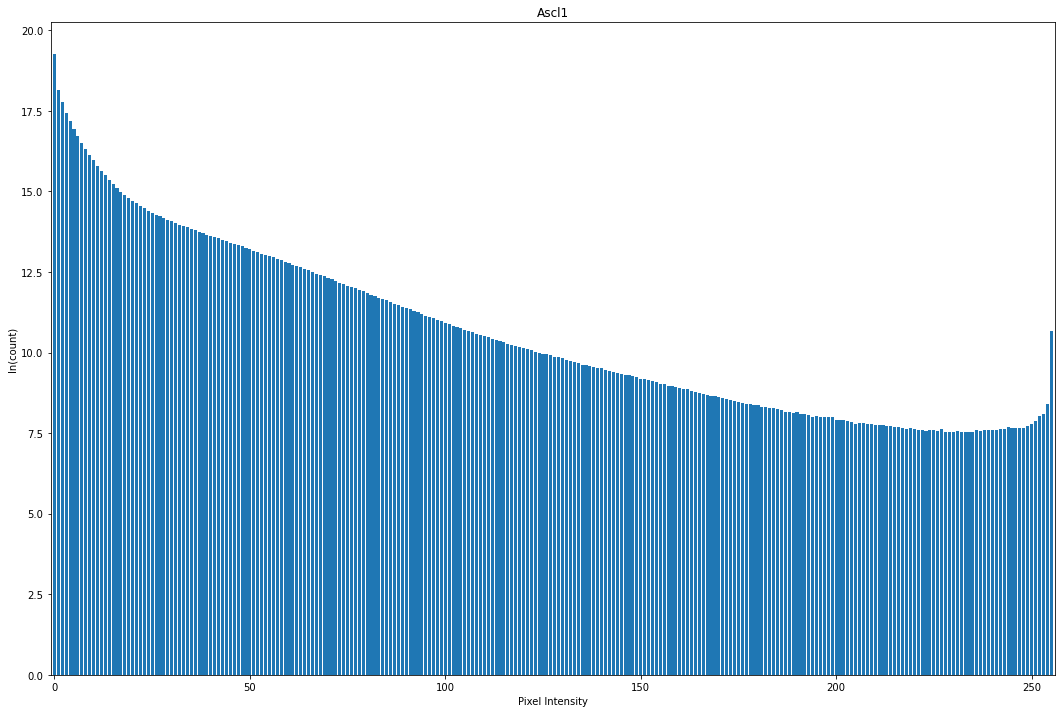

In [4]:
c = Counter()
for fi in tqdm(fluorescent_images):
    c.update(fi.flatten())

print("Empty pixel intensities:")
for i in range(256):
    if i not in c.keys():
        c[i] = 0
        print(i, end=", ")

plt.figure(figsize=(18,12))
plt.bar(range(256), np.log([a[1] for a in sorted(c.items())]))
plt.title(reporter)
plt.xlabel("Pixel Intensity")
plt.ylabel("ln(count)")
plt.xlim([-1,256])
plt.show()

# Obtain mask & feature data

In [5]:
if load_existing:
    with open("saved_output/fluorescence_data/"+reporter+".pickle", "rb") as infile:
        mask_images, result = pickle.load(infile)
else:
    mask_images = \
        Parallel(n_jobs=cpu_count())(
            delayed(get_mask_image_with_refined_offset)(_) for _ in tqdm(brightfield_images))
    result = \
        Parallel(n_jobs=cpu_count())(
            delayed(extract_features)(*_) for _ in tqdm(zip(brightfield_images, mask_images)))
    with open("saved_output/fluorescence_data/"+reporter+".pickle", "wb") as outfile:
        pickle.dump([mask_images, result], outfile)

# Generate label and fluorescence data and write to CSV

In [6]:
df_list = []
class_fluorescences = {}
for i in range(nc):
    class_fluorescences[i] = []
bg_otsu = []
tt_otsu = []
bg_high = []
tt_high = []

if write_data:
    if not os.path.exists("saved_output/fluorescence_data/%s_bf" % reporter):
        os.mkdir("saved_output/fluorescence_data/%s_bf" % reporter)
    if not os.path.exists("saved_output/fluorescence_data/%s_fl" % reporter):
        os.mkdir("saved_output/fluorescence_data/%s_fl" % reporter)

for i in tqdm(range(len(result))):
    df, mask_labels = result[i]
    labels = kmeans.predict(pd.DataFrame(pca.transform(scaler.transform(df)), index=df.index))
    
    if write_data:
        imageio.imwrite(("saved_output/fluorescence_data/%s_bf/%i.png" % (reporter, i)),
                        get_contoured_image(brightfield_images[i], mask_labels, labels, get_colormap()))
        imageio.imwrite(("saved_output/fluorescence_data/%s_fl/%i.png" % (reporter, i)),
                        get_contoured_image(fluorescent_images[i], mask_labels, labels, get_colormap()))

    binarized_fluorescence = \
        cv2.threshold(fluorescent_images[i], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    binarized_fluorescence_otsu = np.uint8(binarized_fluorescence > 0)  # enforces binary value
    cutoff_high = np.percentile(fluorescent_images[i], cutoff_percentile)
    binarized_fluorescence_high = np.uint8(fluorescent_images[i] > cutoff_high)
    
    fluorescences_otsu = np.zeros(len(labels))
    fluorescences_high = np.zeros(len(labels))
    for j in range(len(labels)):
        mask = np.uint8(mask_labels==j+1)  # enforces binary value
        region_fluorescence_otsu = np.sum(mask*binarized_fluorescence_otsu)
        region_fluorescence_high = np.sum(mask*binarized_fluorescence_high)
        fluorescences_otsu[j] = region_fluorescence_otsu
        fluorescences_high[j] = region_fluorescence_high
        class_fluorescences[labels[j]] += [region_fluorescence_high / np.sum(mask),]
    bg_mask = np.uint8(mask_labels==0)
    bg_otsu += [np.sum(bg_mask*binarized_fluorescence_otsu),]
    tt_otsu += [np.sum(binarized_fluorescence_otsu),]
    bg_high += [np.sum(bg_mask*binarized_fluorescence_high),]
    tt_high += [np.sum(binarized_fluorescence_high),]
    
    # Save DataFrame for CSV exporting
    if write_data:
        df = df.reset_index()
        df['image'] = i
        df['label'] = labels
        df['otsu_fluorescence'] = fluorescences_otsu
        df['%s_fluorescence' % str(cutoff_percentile).replace('.', '_')] = fluorescences_high
        df_list += [df.set_index(['image', 'x', 'y']),]

if write_data:
    pd.concat(df_list).to_csv("saved_output/fluorescence_data/%s_fl_data.csv" % reporter)

100%|██████████| 153/153 [24:49<00:00,  9.73s/it]


# Plot analysis data

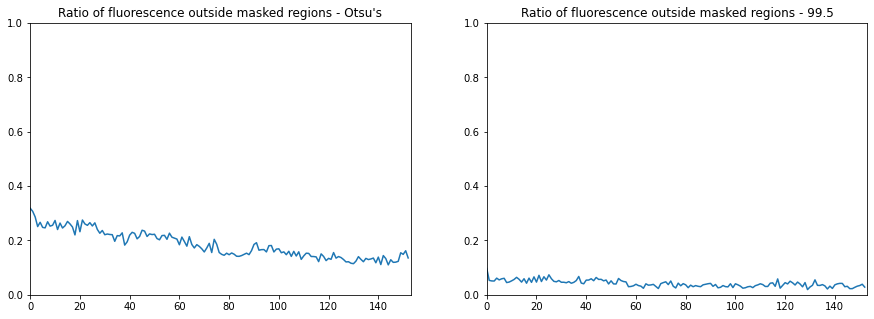

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title("Ratio of fluorescence outside masked regions - Otsu's")
plt.xlim([0,len(result)])
plt.ylim([0,1])
plt.plot(np.array(bg_otsu) / np.array(tt_otsu))

plt.subplot(1,2,2)
plt.title("Ratio of fluorescence outside masked regions - %s" % str(cutoff_percentile))
plt.xlim([0,len(result)])
plt.ylim([0,1])
plt.plot(np.array(bg_high) / np.array(tt_high))
plt.show()

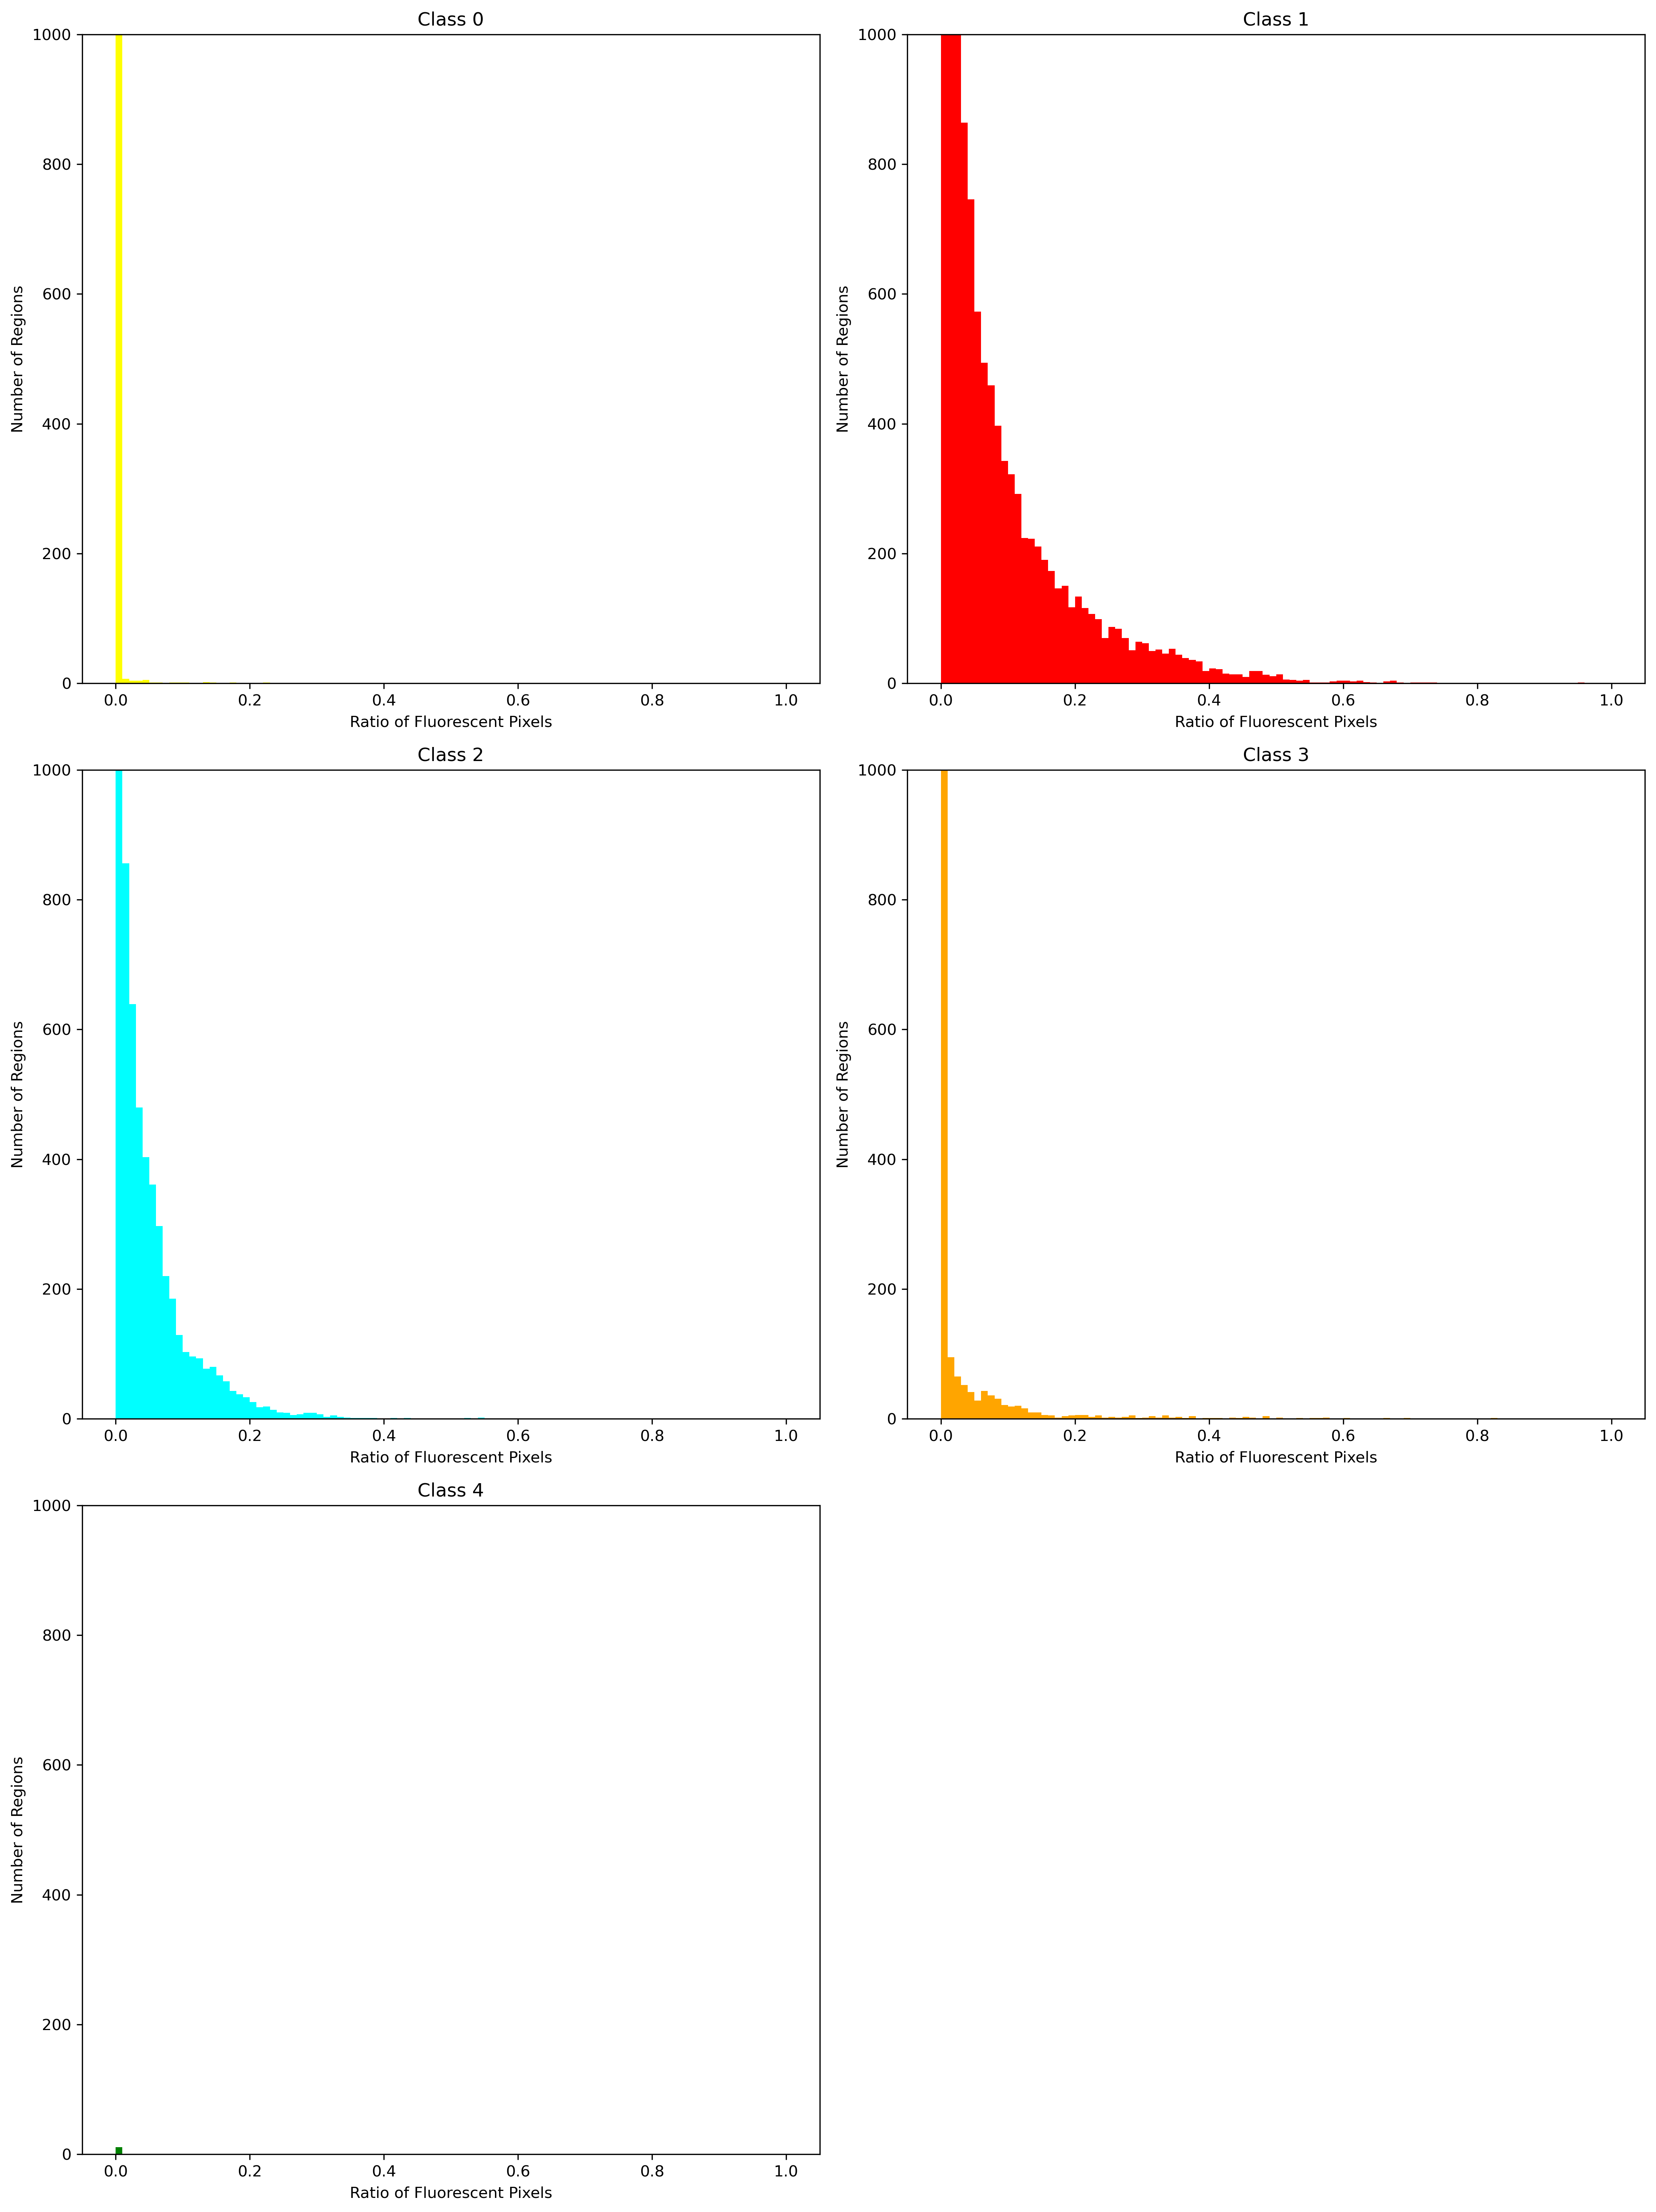

In [8]:
fig, axs = plt.subplots(3, 2, tight_layout=True, figsize=(15, 20), dpi=300)
for k in class_fluorescences.keys():
    axs[int(k/2), k%2].set_title("Class %i" % k)
    axs[int(k/2), k%2].hist(class_fluorescences[k], bins=100, range=[0,1], color=get_color(k))
    axs[int(k/2), k%2].set_ylim(0, 1000)
    axs[int(k/2), k%2].set_ylabel("Number of Regions")
    axs[int(k/2), k%2].set_xlabel("Ratio of Fluorescent Pixels")
axs[-1, -1].axis('off')
pass